In [1]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline

import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
import os
from myutils import *
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score,confusion_matrix
import warnings
from squeeze import *
warnings.filterwarnings("ignore")

CUDA_LAUNCH_BLOCKING=1
fastai.__version__

'1.0.61'

In [2]:
# !kaggle datasets download -d nizamuddin/panda-generating-data2

In [3]:
# !unzip panda-16x128x128-tiles-data.zip -d ./panda-16x128x128-tiles-data > /dev/null
# !rm -rf ./panda-16x128x128-tiles-data/masks
# !ls -l

In [4]:
# !rm -rf ./cache
!rm -rf ./models

In [5]:
# ##remove this cell if run locally
# !rm -rf ./cache
# !mkdir 'cache'
# !mkdir 'cache/torch'
# !mkdir 'cache/torch/checkpoints'
# !cp './se-resnext-weights/sese_resnext101_32x4d-3b2fe3d8.pth' 'cache/torch/checkpoints/'
# torch.hub.DEFAULT_CACHE_DIR = 'cache'

In [6]:
sz = 128
bs = 32
nfolds = 4
SEED = 2020
N = 12 #number of tiles per image
TRAIN = './panda-16x128x128-tiles-data/train/'
LABELS = './train.csv'

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Data  
Use stratified KFold split.

In [8]:
# %%time
# #>>>>>>>>>>IDEMPOTENT<<<<<<<<<<<<<<<<<<<<
# df = pd.read_csv(LABELS).set_index('image_id')
# susp = pd.read_csv('PANDA_Suspicious_Slides.csv')
# #['marks', 'No Mask', 'Background only', 'No cancerous tissue but ISUP Grade > 0', 'tiss', 'blank']
# to_drop = susp.query("reason in ['No Mask','No cancerous tissue but ISUP Grade > 0']")['image_id']
# print("All indices={0} | Bad indices={1} | Good indices used further={2}".format(df.shape[0],len(to_drop),len(list(set(df.index)-set(to_drop)))))

# import glob
# img_list = sorted(glob.glob(os.path.join(TRAIN, '*.png')))
# to_drop_temp=[]
# for file in to_drop:
#     for i in range(0,16):
#         myfile = TRAIN+file+'_{0}.png'.format(i)
#         to_drop_temp.append(myfile)
# to_drop_fullnames = list(set(img_list).intersection(set(to_drop_temp)))
# print(len(to_drop_fullnames))
# import os
# count=0
# err=0
# for file in to_drop_fullnames:
#     try:
#         if os.path.isfile(file):
#             os.remove(file)
#             count+=1
#     except: 
#         err+=1
#         print("Error: %s file not found" % myfile)
# print(count,err)
# #Simple snippet to make sense
# makingsense = []
# for file in to_drop_fullnames:
#     makingsense.append(os.path.isfile(file))
# sum(makingsense)

After filtering bad images: (9954, 3)

>>>>>>>>>Before sampling<<<<<<<<<<<<< (9954, 7)
isup grade: 0 | n_instances: 2843 | corresponding gleason score: ['0+0']
--------------------------------------------------------------------------------
isup grade: 1 | n_instances: 2488 | corresponding gleason score: ['3+3']
--------------------------------------------------------------------------------
isup grade: 2 | n_instances: 1258 | corresponding gleason score: ['3+4' '4+3']
--------------------------------------------------------------------------------
isup grade: 3 | n_instances: 1122 | corresponding gleason score: ['4+3']
--------------------------------------------------------------------------------
isup grade: 4 | n_instances: 1151 | corresponding gleason score: ['4+4' '5+3' '3+5']
--------------------------------------------------------------------------------
isup grade: 5 | n_instances: 1092 | corresponding gleason score: ['4+5' '5+4' '5+5']
----------------------------------------

,image_id,data_provider,isup_grade,gleason_score,split,prim_gleason,secon_gleason
0,49621f6f666d1c54b23d1616ac4beb72,karolinska,1,3+3,3,1,1
1,ab4a7247e87d9cd8b7106a64b3dda927,radboud,5,4+5,0,2,3
2,6468063d0445cf082716fa830a507de2,radboud,0,0+0,0,0,0
3,b2545fbd121c537ccb04c90cef91631c,radboud,2,3+4,3,1,2
4,16e1c7937dc0a2394bf82f863dd1a25f,karolinska,0,0+0,1,0,0


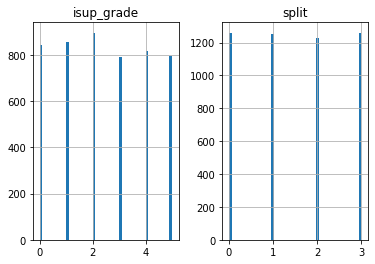

In [9]:
df = pd.read_csv(LABELS).set_index('image_id')
# susp = pd.read_csv('PANDA_Suspicious_Slides.csv')
# #['marks', 'No Mask', 'Background only', 'No cancerous tissue but ISUP Grade > 0', 'tiss', 'blank']
# to_drop = susp.query("reason in ['marks','Background only','tiss','blank']")['image_id']
# files = list(set(df.index)-set(to_drop))#good indices
# print("All indices={0} | Bad indices={1} | Good indices used further={2}".format(df.shape[0],len(to_drop),len(files)))
# df = df.loc[files]
# print("After filtering bad images:",df.shape)
files = sorted(set([p[:32] for p in os.listdir(TRAIN)]))

df = df.loc[files]
print("After filtering bad images:",df.shape)

df = df.reset_index()

splits = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
splits = list(splits.split(df,df.isup_grade))
folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(nfolds): 
    folds_splits[splits[i][1]] = i
df['split'] = folds_splits
df['gleason_score']=df['gleason_score'].replace('negative','0+0')
df[['prim_gleason','secon_gleason']] = df.gleason_score.str.split("+",expand=True)
df[['prim_gleason','secon_gleason']] = df[['prim_gleason','secon_gleason']].astype(np.int64)
df['prim_gleason']=df['prim_gleason'].replace(3,1)
df['prim_gleason']=df['prim_gleason'].replace(4,2)
df['prim_gleason']=df['prim_gleason'].replace(5,3)
df['secon_gleason']=df['secon_gleason'].replace(3,1)
df['secon_gleason']=df['secon_gleason'].replace(4,2)
df['secon_gleason']=df['secon_gleason'].replace(5,3)
print("\n>>>>>>>>>Before sampling<<<<<<<<<<<<<",df.shape)
for isup in [0,1,2,3,4,5]:
    print("isup grade:",isup,"| n_instances:",df.query('isup_grade=={0}'.format(isup)).shape[0],"| corresponding gleason score:",df[['isup_grade','gleason_score']].query('isup_grade=={0}'.format(isup))['gleason_score'].unique())
    print("----"*20)
#df.drop([df[df['image_id']=="b0a92a74cb53899311acc30b7405e101"].index[0]],inplace=True)
#b0a92a74cb53899311acc30b7405e101 is the only image id with gleason 4+3 mapping to isup=2
df = pd.concat([df.query('isup_grade==0').iloc[:1200],df.query('isup_grade==1').iloc[:1200],df.query('isup_grade==2 or isup_grade==3 or isup_grade==4 or isup_grade==5')],axis=0)
print("\n>>>>>>>>>After Balancing data manually by selecting first 1200 from isup_grades 0 and 1<<<<<<<<<<<<<",df.shape)
for isup in [0,1,2,3,4,5]:
    print("isup grade:",isup,"| n_instances:",df.query('isup_grade=={0}'.format(isup)).shape[0],"| corresponding gleason score:",df[['isup_grade','gleason_score']].query('isup_grade=={0}'.format(isup))['gleason_score'].unique())
    print("----"*20)
df = df.sample(n=5000,random_state=SEED).reset_index(drop=True)#shuffling
print("\n>>>>>>>>>After sampling<<<<<<<<<<",df.shape)
for isup in [0,1,2,3,4,5]:
    print("isup grade:",isup,"| n_instances:",df.query('isup_grade=={0}'.format(isup)).shape[0],"| corresponding gleason score:",df[['isup_grade','gleason_score']].query('isup_grade=={0}'.format(isup))['gleason_score'].unique())
    print("----"*20)
df[['isup_grade','split']].hist(bins=50)
df.head()

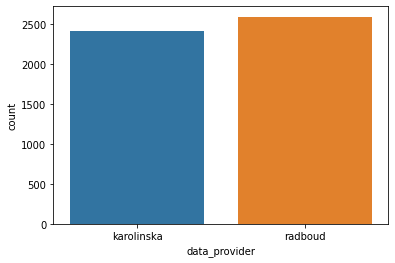

In [10]:
import seaborn as sns
sns.countplot(df['data_provider'])


Check [this kernel](https://www.kaggle.com/iafoss/panda-16x128x128-tiles) for image stats. Since I use zero padding and background corresponds to 255, I invert images as 255-img when load them. Therefore, the mean value is computed as '1 - val'.

In [11]:
mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])
#mean: [0.96589806 0.9326964  0.95441414] , std: [0.30177967 0.4173849  0.33891267]for 224

The code below (in the hidden cell) creates ImageItemList capable of loading multiple tiles of an image. It is specific for fast.ai, and pure Pytorch code would be much simpler.

In [12]:
def open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,after_open:Callable=None)->Image:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(fn).convert(convert_mode)
    if after_open: 
        x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: 
        x.div_(255)
    return cls(1.0-x) #invert image for zero padding

class MImage(ItemBase):
    def __init__(self, imgs):
        self.obj  = (imgs)
        self.data = [(imgs[i].data - mean[...,None,None])/std[...,None,None] for i in range(len(imgs))]
    
    def apply_tfms(self, tfms,*args, **kwargs):
        for i in range(len(self.obj)):
            self.obj[i] = self.obj[i].apply_tfms(tfms, *args, **kwargs)
            self.data[i] = (self.obj[i].data - mean[...,None,None])/std[...,None,None]
        return self
    
    def __repr__(self): 
        return f'{self.__class__.__name__} {img.shape for img in self.obj}'
    
    def to_one(self):
        img = torch.stack(self.data,1)
        img = img.view(3,-1,N,sz,sz).permute(0,1,3,2,4).contiguous().view(3,-1,sz*N)
        return Image(1.0 - (mean[...,None,None]+img*std[...,None,None]))

class MImageItemList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __len__(self)->int: return len(self.items) or 1 
    
    def get(self, i):
        fn = Path(self.items[i])
        fnames = [Path(str(fn)+'_'+str(i)+'.png')for i in range(N)]
        imgs = [open_image(fname, convert_mode=self.convert_mode, after_open=self.after_open)
               for fname in fnames]
        return MImage(imgs)

    def reconstruct(self, t):
        return MImage([mean[...,None,None]+_t*std[...,None,None] for _t in t])
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(300,50), **kwargs):
        rows = min(len(xs),8)
        fig, axs = plt.subplots(rows,1,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        

#collate function to combine multiple images into one tensor
def MImage_collate(batch:ItemsList)->Tensor:
    result = torch.utils.data.dataloader.default_collate(to_data(batch))
    if isinstance(result[0],list):
        result = [torch.stack(result[0],1),result[1]]
    return result

In [13]:
'dc4034659aa2ae3585cdbe6febd3540b' in list(df['image_id']),torch.cuda.get_device_name(),torch.cuda.get_device_properties(0)


(False,
 'Tesla T4',
 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40))

In [14]:
def get_data(fold=0):
    return (MImageItemList.from_df(df, path='.', folder=TRAIN, cols='image_id')
      .split_by_idx(df.index[df.split == fold].tolist())
      .label_from_df(cols=['isup_grade'])
      .transform(get_transforms(flip_vert=True,max_rotate=15),size=sz,padding_mode='zeros')
      .databunch(bs=bs,num_workers=4,device='cuda'))
data = get_data(0)
#data.show_batch()

In [15]:
# i[1] contains labels, indicating isup grades
# preds,y,losses = learn.get_preds(with_loss=True)
# interp = ClassificationInterpretation(learn, preds, y, losses)
for i in data.dl():
    print(i[0][0].shape,i[0][7].shape,i[1].shape)
    break

torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128]) torch.Size([32])


# Model

The code below implements Concat Tile pooling idea. As a backbone I use [Semi-Weakly Supervised ImageNet pretrained ResNeXt50 model](https://github.com/facebookresearch/semi-supervised-ImageNet1K-models), which worked for me quite well in a number of previous competitions.

### ResNeSt,  
employs Split-Attention block that enables attention across feature-map groups by stacking these Split-Attention blocks ResNet-style. Better results on 224 x 224.  
m = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)

In [16]:
# from squeeze import *
# m = se_resnext101_32x4d(6,loss='softmax', pretrained=True)
# len(list(nn.Sequential(*list(m.children())[:-2])))

In [28]:
class Model(nn.Module):
    def __init__(self, n=6, pre=True):
        super().__init__()
        #m = se_resnext101_32x4d(n,loss='softmax', pretrained=True)
        m = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)

        self.enc = nn.Sequential(*list(m.children())[:-2])       
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(AdaptiveConcatPool2d(),
                                  Flatten(),
                                  nn.Linear(2*nc,512),
                                  Mish(),
                                  nn.BatchNorm1d(512), 
                                  nn.Dropout(0.5),
                                  nn.Linear(512,256),
                                  Mish(),
                                  nn.BatchNorm1d(256), 
                                  nn.Dropout(0.3),
                                  nn.Linear(256,n))
        
        
    def forward(self, *x):
        shape = x[0].shape
        n = len(x)
        x = torch.stack(x,1).view(-1,shape[1],shape[2],shape[3])
        #x: bs*N x 3 x 128 x 128
        x = self.enc(x)
        #x: bs*N x C x 4 x 4
        shape = x.shape
        #concatenate the output for tiles into a single map
        x = x.view(-1,n,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous().view(-1,shape[1],shape[2]*n,shape[3])
        #x: bs x C x N*4 x 4
        x = self.head(x)
        #x: bs x n
        return x

In [29]:
# data  = get_data(3)
# model = Model()
# gleason_loss = LabelSmoothingCrossEntropy()
# learn = Learner(data,model,loss_func=gleason_loss, opt_func=Over9000, metrics=[KappaScore(weights='quadratic')]).to_fp16()
# learn.loss_func=learn.loss_func.to('cuda')
# learn.model=learn.model.to('cuda')
# learn.clip_grad = 1.0
# learn.split([learn.model.enc[0],learn.model.enc[1],learn.model.enc[2],learn.model.enc[3],learn.model.enc[4],learn.model.head])
# learn.freeze()#first, train only the last layer(the heads)

In [30]:
# learn.lr_find()
# learn.recorder.plot()
# plt.title("Loss Vs Learning Rate")

In [31]:

# learn.fit_one_cycle(5, max_lr=1e-2,div_factor=100,pct_start=0.0,callbacks = [SaveModelCallback(learn,name='stage1',monitor='kappa_score')])


In [32]:
# learn.load('stage1')
# learn.unfreeze()

In [33]:

# learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-3),div_factor=100,pct_start=0.0,callbacks = [SaveModelCallback(learn,name='stage2',monitor='kappa_score')])


In [34]:
fname = 'ResNeSt50'
pred,target = [],[]
for fold in range(nfolds):#nfolds
    print("-"*40,"Fold-",fold,"-"*40)
    data  = get_data(fold)
    model = Model()
    gleason_loss = LabelSmoothingCrossEntropy()
    learn = Learner(data,model,loss_func=gleason_loss, opt_func=Over9000, metrics=[KappaScore(weights='quadratic')]).to_fp16()
    learn.loss_func=learn.loss_func.to('cuda')
    learn.model=learn.model.to('cuda')
    learn.clip_grad = 1.0
    learn.split([learn.model.enc[0],learn.model.enc[1],learn.model.enc[2],learn.model.enc[3],learn.model.enc[4],learn.model.head])
    learn.freeze()#first, train only the last layer(the heads)
    learn.fit_one_cycle(5, max_lr=1e-2, div_factor=100, pct_start=0.0, 
      callbacks = [SaveModelCallback(learn,name='stage1_{0}'.format(fold),monitor='kappa_score')])
    logger = CSVLogger(learn, f'log_{fname}_{fold}')
    learn.load('stage1_{0}'.format(fold))
    learn.unfreeze()
    learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4), div_factor=100, pct_start=0.0, 
      callbacks = [SaveModelCallback(learn,name='stage2_{0}'.format(fold),monitor='kappa_score')])
    
    torch.save(learn.model.state_dict(), f'{fname}_{fold}.pth')
    
    learn.model.eval()
    with torch.no_grad():
        for step, (x, y) in progress_bar(enumerate(data.dl(DatasetType.Valid)),
                                     total=len(data.dl(DatasetType.Valid))):
            p = learn.model(*x)
            pred.append(p.float().cpu())
            target.append(y.cpu())


---------------------------------------- Fold- 0 ----------------------------------------


Using cache found in /home/nizamphoenix/.cache/torch/hub/zhanghang1989_ResNeSt_master
Downloading: "https://s3.us-west-1.wasabisys.com/resnest/torch/resnest50-528c19ca.pth" to /home/nizamphoenix/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth


epoch,train_loss,valid_loss,kappa_score,time
0,1.716441,1.740840,0.424213,01:54
1,1.609540,1.562849,0.546278,01:44
2,1.555106,1.585436,0.541111,01:43
3,1.507672,1.546921,0.549565,01:43
4,1.491108,1.532131,0.552602,01:43


Better model found at epoch 0 with kappa_score value: 0.424213171005249.
Better model found at epoch 1 with kappa_score value: 0.5462782979011536.
Better model found at epoch 3 with kappa_score value: 0.5495650768280029.
Better model found at epoch 4 with kappa_score value: 0.5526024103164673.


epoch,train_loss,valid_loss,kappa_score,time
0,1.489176,1.531855,0.546759,02:23
1,1.498204,1.532886,0.553048,02:19
2,1.479460,1.533432,0.545248,02:18
3,1.487870,1.524358,0.560799,02:18
4,1.482079,1.535971,0.537549,02:19


Better model found at epoch 0 with kappa_score value: 0.5467586517333984.
Better model found at epoch 1 with kappa_score value: 0.5530480146408081.
Better model found at epoch 3 with kappa_score value: 0.5607990026473999.


---------------------------------------- Fold- 1 ----------------------------------------


Using cache found in /home/nizamphoenix/.cache/torch/hub/zhanghang1989_ResNeSt_master


epoch,train_loss,valid_loss,kappa_score,time
0,1.715122,1.624592,0.528082,01:44
1,1.630028,1.591532,0.511524,01:43
2,1.552585,1.525147,0.573774,01:43
3,1.522873,1.539355,0.546979,01:43
4,1.499598,1.534495,0.558788,01:43


Better model found at epoch 0 with kappa_score value: 0.528082013130188.
Better model found at epoch 2 with kappa_score value: 0.573773980140686.


epoch,train_loss,valid_loss,kappa_score,time
0,1.528646,1.531099,0.576496,02:18
1,1.518194,1.532747,0.564292,02:19
2,1.529488,1.532069,0.574970,02:19
3,1.513968,1.529929,0.568994,02:18
4,1.517781,1.525247,0.569513,02:19


Better model found at epoch 0 with kappa_score value: 0.5764960050582886.


---------------------------------------- Fold- 2 ----------------------------------------


Using cache found in /home/nizamphoenix/.cache/torch/hub/zhanghang1989_ResNeSt_master


epoch,train_loss,valid_loss,kappa_score,time
0,1.703293,1.714737,0.521575,01:45
1,1.628542,1.575683,0.569876,01:43
2,1.560730,1.544438,0.574122,01:43
3,1.529143,1.533996,0.587949,01:43
4,1.496002,1.526058,0.596610,01:43


Better model found at epoch 0 with kappa_score value: 0.5215752124786377.
Better model found at epoch 1 with kappa_score value: 0.569875955581665.
Better model found at epoch 2 with kappa_score value: 0.5741219520568848.
Better model found at epoch 3 with kappa_score value: 0.5879493951797485.
Better model found at epoch 4 with kappa_score value: 0.5966101288795471.


epoch,train_loss,valid_loss,kappa_score,time
0,1.483028,1.521877,0.601602,02:18
1,1.506802,1.523548,0.592051,02:19
2,1.489879,1.521800,0.600886,02:18
3,1.501159,1.529810,0.597359,02:19
4,1.497228,1.520819,0.601226,02:18


Better model found at epoch 0 with kappa_score value: 0.6016018390655518.


---------------------------------------- Fold- 3 ----------------------------------------


Using cache found in /home/nizamphoenix/.cache/torch/hub/zhanghang1989_ResNeSt_master


epoch,train_loss,valid_loss,kappa_score,time
0,1.704351,1.725681,0.476936,01:44
1,1.617252,1.596856,0.512582,01:43
2,1.561784,1.617761,0.498972,01:43
3,1.521649,1.577744,0.515909,01:43
4,1.495279,1.556941,0.555457,01:43


Better model found at epoch 0 with kappa_score value: 0.4769356846809387.
Better model found at epoch 1 with kappa_score value: 0.5125824213027954.
Better model found at epoch 3 with kappa_score value: 0.5159088373184204.
Better model found at epoch 4 with kappa_score value: 0.5554567575454712.


epoch,train_loss,valid_loss,kappa_score,time
0,1.489959,1.562913,0.546602,02:18
1,1.479957,1.564473,0.549723,02:17
2,1.489479,1.559208,0.557296,02:18
3,1.479342,1.561334,0.555277,02:18
4,1.484606,1.557518,0.550951,02:18


Better model found at epoch 0 with kappa_score value: 0.5466022491455078.
Better model found at epoch 1 with kappa_score value: 0.5497226119041443.
Better model found at epoch 2 with kappa_score value: 0.5572963953018188.


In [35]:
p = torch.argmax(torch.cat(pred,dim=0),1)      
t = torch.cat(target)
print(cohen_kappa_score(t,p,weights='quadratic'))      
print(confusion_matrix(t,p))

0.5738310178838769
[[572  96  24  31 100  19]
 [267 192 157  71 156  14]
 [128 116 261 165 191  35]
 [ 60  36 105 229 255 106]
 [ 68  47  62 123 402 115]
 [ 53  12  50 104 222 356]]


#### -------------------------------------------------------------------------- End --------------------------------------------------------------------

In [ ]:
# m = torch.hub.load('facebookresearch/detr', model='detr_resnet50')
# there are 8 blocks in resnext 50
# print(list(m.children())[:-2][0],'\n',list(m.children())[:-2][1],'\n',list(m.children())[:-2][2],'\n',list(m.children())[:-2][3])
# for i in [4,5,6,7]:
#     print(list(m.children())[:-2][i])
#     print("-"*100)#,list(m.children())[:-2][5],list(m.children())[:-2][6],list(m.children())[:-2][7]

# Training

In [ ]:
def get_isup_preds_targs(preds,target):
    lookup_map = {(0,0):0,(1,1):1,(1,2):2,(2,1):3,(2,2):4,(3,1):4,(1,3):4,(2,3):5,(3,2):5,(3,3):5}
    lookup_map2 = {(0,1):1,(0,2):1,(0,3):2,(1,0):1,(2,0):3,(3,0):4}#or all 0
    prim_preds = preds[0].argmax(-1).view(-1,1)
    sec_preds  = preds[1].argmax(-1).view(-1,1)
    temp_preds = torch.cat([prim_preds,sec_preds],dim=1)
    temp = []
    count = 0
    errors = 0
    for i in np.array(temp_preds.cpu()):
        count+=1
        try:
            temp.append(lookup_map[tuple(i)])
        except KeyError:
            #print(tuple(i)," missins")
            errors+=1
            temp.append(lookup_map2[tuple(i)])
    print("count={0} | errors={1}".format(count,errors)," | correct=",count-errors)
    isup_preds = torch.tensor(temp,dtype=torch.long,device='cpu')
    temp = []
    for i in np.array(target.cpu()):
        temp.append(lookup_map[tuple(i)])
    isup_targs = torch.tensor(temp,dtype=torch.long,device='cpu')    
    return isup_preds,isup_targs

In [ ]:
class ConfusionMatrix(Callback):
    "Computes the confusion matrix."

    def on_train_begin(self, **kwargs):
        self.n_classes = 0

    def on_epoch_begin(self, **kwargs):
        self.cm = None

    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.cpu()
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
        if self.cm is None: self.cm = torch.zeros((self.n_classes, self.n_classes), device=torch.device('cpu'))
        cm_temp_numpy = self.cm.numpy()
        np.add.at(cm_temp_numpy, (targs ,preds), 1)
        self.cm = torch.from_numpy(cm_temp_numpy)

    def on_epoch_end(self, **kwargs):
        self.metric = self.cm
        
@dataclass
class KappaScore(ConfusionMatrix):
    "Computes the rate of agreement (Cohens Kappa)."
    weights:Optional[str]=None      # None, `linear`, or `quadratic`
        
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
#         print("Customised scoring function....")
#         print(last_output[0].shape,last_output[1].shape,last_target.shape)
#         print(last_output)
#         print(last_target)
        preds,targs = get_isup_preds_targs(last_output,last_target)#convert gleasons-->isup for evaluatio

        if self.n_classes == 0:
            self.n_classes = 6 #n_classes in isup_grade
        if self.cm is None: 
            #This executes only once
            self.cm = torch.zeros((self.n_classes, self.n_classes), device=torch.device('cpu'))
        cm_temp_numpy = self.cm.numpy()
        np.add.at(cm_temp_numpy, (targs ,preds), 1)
        self.cm = torch.from_numpy(cm_temp_numpy)
        
        
    def on_epoch_end(self, last_metrics, **kwargs):
        sum0 = self.cm.sum(dim=0)
        sum1 = self.cm.sum(dim=1)
        expected = torch.einsum('i,j->ij', (sum0, sum1)) / sum0.sum()
        if self.weights is None:
            w = torch.ones((self.n_classes, self.n_classes))
            w[self.x, self.x] = 0
        elif self.weights == "linear" or self.weights == "quadratic":
            w = torch.zeros((self.n_classes, self.n_classes))
            w += torch.arange(self.n_classes, dtype=torch.float)
            w = torch.abs(w - torch.t(w)) if self.weights == "linear" else (w - torch.t(w)) ** 2
        else: raise ValueError('Unknown weights. Expected None, "linear", or "quadratic".')
        k = torch.sum(w * self.cm) / torch.sum(w * expected)
        return add_metrics(last_metrics, 1-k)

In [ ]:
def get_resnext(layers, pretrained, progress, **kwargs):
    from torchvision.models.resnet import ResNet, Bottleneck
    model = ResNet(Bottleneck, layers, **kwargs)
    model.load_state_dict(torch.load('./resnext-50-ssl/semi_supervised_resnext50_32x4-ddb3e555.pth'))
    return model


class GleasonModel(nn.Module):
    '''
    Multi-task neural network trained on major(primary) and minor(secondary) gleason scores instead of
    isup grade.
    Backbones:-
    1.resnext:'facebookresearch/semi-supervised-ImageNet1K-models',model='resnext50_32x4d_ssl'
    2.resnest:'zhanghang1989/ResNeSt', model='resnest50'
    3.seresnext: https://kaiyangzhou.github.io/deep-person-reid/pkg/
    3.detr:
    '''
    def __init__(self, n=4):#n=4 since model is trained on gleason scores
        super().__init__()
        #m = torch.hub.load(github='facebookresearch/detr', model='detr_resnet50_dc5', pretrained=True)
        m = se_resnext50_32x4d(4,loss='softmax', pretrained=True)
        
        #m = get_resnext([3, 4, 6, 3], pretrained=True, progress=False, groups=32,width_per_group=4)
        self.enc = nn.Sequential(*list(m.children())[:-2])       
        nc = list(m.children())[-1].in_features
        self.head = nn.Sequential(AdaptiveConcatPool2d(),
                                  Flatten(),
#                                   nn.Linear(2*nc,512),
#                                   Mish(),
#                                   nn.BatchNorm1d(512), 
#                                   nn.Dropout(0.5),
                                  nn.Linear(2*nc,512),
                                  Mish(),
                                  nn.BatchNorm1d(512), 
                                  nn.Dropout(0.3))
        self.prim =  nn.Linear(512,n)
        self.sec  =  nn.Linear(512,n)
      
        
        
    def forward(self, *x):
        shape = x[0].shape
        n = len(x)
        x = torch.stack(x,1).view(-1,shape[1],shape[2],shape[3])
        #x: bs*N x 3 x 128 x 128
        x = self.enc(x)
        #x: bs*N x C x 4 x 4
        shape = x.shape
        #concatenate the output for tiles into a single map
        x = x.view(-1,n,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous().view(-1,shape[1],shape[2]*n,shape[3])
        #x: bs x C x N*4 x 4
        x = self.head(x)
        #x: bs x n
        prim_gleason = self.prim(x)
        sec_gleason  = self.sec(x)
        preds = [prim_gleason,sec_gleason]
        return preds

In [ ]:
class MultiTaskGleasonLoss(nn.Module):
    def __init__(self, task_num):
        super(MultiTaskGleasonLoss, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, preds, targets):
#         print("type(preds):",type(preds),"| len(preds):",len(preds),"| preds[0].shape:",preds[0].shape,"| preds[1].shape:",preds[1].shape)
#         print("type(targets):",type(targets),"| targets[:,0].shape:",targets[:,0].shape,"| targets[:,1].shape:",targets[:,1].shape)
        crossEntropy = nn.CrossEntropyLoss()
#         print("Before typecasting: ",preds[0].device,preds[0].dtype,targets[:,0].device,targets[:,0].dtype)
        prim_preds  = preds[0]
        prim_target = targets[:,0].long()
        loss1 = crossEntropy(prim_preds,prim_target)
#         print("After typecasting: ",prim_preds.device,prim_preds.dtype,prim_target.device,prim_target.dtype)
        precision1 = torch.exp(-self.log_vars[0])
        loss1 = precision1*loss1 + self.log_vars[0]   
        
        sec_preds  = preds[1]
        sec_target = targets[:,1].long()
        loss2 = crossEntropy(sec_preds,sec_target)
        precision2 = torch.exp(-self.log_vars[1])
        loss2 = precision2*loss2 + self.log_vars[1]   
        
        return loss1+loss2


In [ ]:
data  = get_data(0)
model = GleasonModel()
gleason_loss = MultiTaskGleasonLoss(2)
learn = Learner(data,model,loss_func=gleason_loss, opt_func=Over9000, metrics=[KappaScore(weights='quadratic')]).to_fp16()
learn.loss_func=learn.loss_func.to('cuda')
learn.model=learn.model.to('cuda')
learn.clip_grad = 1.0
learn.split([learn.model.head,nn.ModuleList([learn.model.prim,learn.model.sec])])
learn.freeze()#first, train only the last layer(the heads)

In [ ]:
learn.lr_find()
learn.recorder.plot()
plt.title("Loss Vs Learning Rate")

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-1, div_factor=25, pct_start=0.0, callbacks = [SaveModelCallback(learn,name='freezed_trained',monitor='kappa_score')])

In [ ]:
learn.load('stage2')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()
plt.title("Loss Vs Learning Rate")

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-2), div_factor=25, pct_start=0.0, 
      callbacks = [SaveModelCallback(learn,name='stage2',monitor='kappa_score')])
    

In [ ]:
fname = 'RNXT50'
pred,target = [],[]
for fold in range(nfolds):#nfolds
    print("-"*40,"Fold-",fold,"-"*40)
    data  = get_data(fold)
    model = GleasonModel()
    gleason_loss = MultiTaskGleasonLoss(2)
    learn = Learner(data,model,loss_func=gleason_loss, opt_func=Over9000, metrics=[KappaScore(weights='quadratic')]).to_fp16()
    learn.loss_func=learn.loss_func.to('cuda')
    learn.model=learn.model.to('cuda')
    learn.clip_grad = 1.0
    learn.split([learn.model.enc[0:6],learn.model.enc[6:8],learn.model.head,nn.ModuleList([learn.model.prim,learn.model.sec])])
    learn.freeze()
    learn.fit_one_cycle(2, max_lr=1e-1, div_factor=100, pct_start=0.0, 
      callbacks = [SaveModelCallback(learn,name='stage1_{0}'.format(fold),monitor='kappa_score')])
    logger = CSVLogger(learn, f'log_{fname}_{fold}')
    learn.load('stage1_{0}'.format(fold))
    learn.unfreeze()
    learn.fit_one_cycle(3, max_lr=slice(1e-5,1e-3), div_factor=100, pct_start=0.0, 
      callbacks = [SaveModelCallback(learn,name='stage2_{0}'.format(fold),monitor='kappa_score')])
    
    torch.save(learn.model.state_dict(), f'{fname}_{fold}.pth')
    
    learn.model.eval()
    with torch.no_grad():
        for step, (x, y) in progress_bar(enumerate(data.dl(DatasetType.Valid)),total=len(data.dl(DatasetType.Valid))):
            #print(len(x),x[0].shape)
            p = learn.model(*x) 
            preds,targs = get_isup_preds_targs(p,y)
            pred.append(preds)
            target.append(targs)

In [ ]:
p = torch.argmax(torch.cat(pred,dim=0),1)      
t = torch.cat(target)
print(cohen_kappa_score(t,p,weights='quadratic'))
print(confusion_matrix(t,p))

In [ ]:
confusion_matrix(torch.cat(target),torch.cat(pred,dim=0))

In [ ]:
cohen_kappa_score(torch.cat(target),torch.cat(pred,dim=0),weights='quadratic')

In [ ]:
!rm -r 'cache'

In [ ]:
# !pip install -q torchviz
# import torch
# from torchviz import make_dot
# model = Model()
# x = torch.randn(2, 3, 128, 128).requires_grad_(True)
# y = model(x)
# make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)])).render("attached")

In [ ]:
# class Model(nn.Module):
#     def __init__(self, arch='resnext50_32x4d_ssl', n=6, pre=True):
#         super().__init__()
#         #m = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
#         m = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', arch)
#         self.enc = nn.Sequential(*list(m.children())[:-2])       
#         nc = list(m.children())[-1].in_features
#         self.head = nn.Sequential(AdaptiveConcatPool2d(),
#                                   Flatten(),
#                                   nn.Linear(2*nc,128),
#                                   Mish(),
#                                   nn.BatchNorm1d(128), 
#                                   nn.Dropout(0.5),
#                                   nn.Linear(128,n))
        
        
#     def forward(self, *x):
#         shape = x[0].shape
#         n = len(x)
#         x = torch.stack(x,1).view(-1,shape[1],shape[2],shape[3])
#         #x: bs*N x 3 x 128 x 128
#         x = self.enc(x)
#         #x: bs*N x C x 4 x 4
#         shape = x.shape
#         #concatenate the output for tiles into a single map
#         x = x.view(-1,n,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous().view(-1,shape[1],shape[2]*n,shape[3])
#         #x: bs x C x N*4 x 4
#         x = self.head(x)
#         #x: bs x n
#         return x

In [ ]:
# #UNDERSAMPLING
# import seaborn as sns
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=SEED)
# X_resampled, y_resampled = rus.fit_resample(df[['image_id', 'data_provider','split']].iloc[:8000], df['isup_grade'].iloc[:8000])
# df = pd.concat([pd.DataFrame(X_resampled,columns=['image_id', 'data_provider','split']),pd.DataFrame(y_resampled,columns=['isup_grade'])],axis=1)
# df = df.sample(frac=1,random_state=SEED).reset_index(drop=True)
# sns.countplot(df['isup_grade'])
# df.head()
# df = df.groupby(['split'], group_keys=False).apply(lambda x: x.sample(min(len(x), 1000),random_state=SEED))
# df[['isup_grade','split']].hist(bins=50)

In [ ]:
# t1=torch.tensor([[-8.8875e+01,  3.9062e+01, -6.1406e+00, -6.6625e+01],
#         [-3.3781e+01,  1.4578e+01, -8.6133e-01, -2.5047e+01],
#         [-2.9297e+00,  1.2412e+00,  9.8584e-01, -2.6113e+00],
#         [-1.6992e-01,  3.9355e-01,  4.3701e-01, -1.1953e+00],
#         [-5.7910e-01,  6.8457e-01,  4.6216e-01, -1.4893e+00],
#         [-1.7639e-01,  4.2603e-01,  3.8843e-01, -1.2490e+00],
#         [-1.6297e+01,  7.1523e+00,  4.3018e-01, -1.2164e+01],
#         [-1.6333e-01,  4.3164e-01,  3.7207e-01, -1.2646e+00],
#         [-4.8309e-02,  4.4946e-01,  3.0298e-01, -1.1963e+00],
#         [-3.6844e+01,  1.6312e+01, -2.1621e+00, -2.7594e+01],
#         [        0,         1,         0,         0],
#         [-7.6721e-02,  4.3408e-01,  3.4644e-01, -1.1943e+00],
#         [-8.0875e+01,  3.5188e+01, -3.9707e+00, -5.9656e+01],
#         [-6.1625e+01,  2.7312e+01, -3.2949e+00, -4.6594e+01],
#         [-3.5906e+01,  1.5633e+01, -9.3945e-01, -2.6281e+01],
#         [-2.1641e+01,  9.4062e+00,  6.9385e-01, -1.5695e+01],
#         [-2.8781e+01,  1.2414e+01,  4.8706e-01, -2.0859e+01],
#         [-3.0266e+01,  1.3586e+01, -1.4209e+00, -2.2922e+01],
#         [        0,         1,         0,         0],
#         [-3.6531e+01,  1.6172e+01, -1.5479e+00, -2.7625e+01],
#         [-6.9580e-02,  4.5190e-01,  3.1958e-01, -1.2119e+00],
#         [-6.0181e-02,  4.5117e-01,  3.1421e-01, -1.2178e+00],
#         [-2.8711e-01,  3.8086e-01,  4.9854e-01, -1.2412e+00],
#         [-4.4373e-02,  4.3896e-01,  3.1714e-01, -1.1748e+00],
#         [-6.0028e-02,  4.4263e-01,  3.2349e-01, -1.1914e+00],
#         [-9.6741e-02,  4.4019e-01,  3.5449e-01, -1.2178e+00],
#         [-3.0762e+00,  1.5293e+00,  6.8506e-01, -2.8242e+00],
#         [-5.3345e-02,  4.5386e-01,  3.0737e-01, -1.2119e+00],
#         [-1.2711e+01,  5.7656e+00,  3.3203e-01, -9.6797e+00],
#         [-6.6406e-02,  4.4727e-01,  3.2471e-01, -1.1963e+00],
#         [-4.9042e-02,  4.3872e-01,  3.0420e-01, -1.1709e+00],
#         [-1.6641e+00,  1.1172e+00,  5.8203e-01, -2.0605e+00]])
# t2=torch.tensor([[-5.9812e+01,  1.6828e+01, -1.5188e+01,  4.7781e+01],
#         [-2.2938e+01,  7.0039e+00, -5.7188e+00,  1.8125e+01],
#         [-2.1074e+00,  8.9258e-01, -4.4336e-01,  1.7598e+00],
#         [-4.0796e-01,  5.6299e-01, -8.6121e-02, -2.2437e-01],
#         [-5.1025e-01,  8.9648e-01, -3.6938e-01, -2.2949e-02],
#         [-4.5142e-01,  6.2695e-01, -2.0935e-01, -1.9116e-01],
#         [-1.1297e+01,  3.5859e+00, -2.5879e+00,  8.7109e+00],
#         [-4.3408e-01,  6.1182e-01, -1.8848e-01, -2.2412e-01],
#         [-2.7954e-01,  5.9863e-01, -2.1533e-01, -3.5278e-01],
#         [-2.4562e+01,  7.7227e+00, -7.1094e+00,  2.0703e+01],
#         [        0,         1,         0,         0],
#         [-3.1030e-01,  5.6934e-01, -1.3806e-01, -3.4082e-01],
#         [-5.5281e+01,  1.5883e+01, -1.3398e+01,  4.2781e+01],
#         [-4.1875e+01,  1.1969e+01, -1.0406e+01,  3.2938e+01],
#         [-2.4562e+01,  7.4766e+00, -6.0117e+00,  1.9375e+01],
#         [-1.5336e+01,  5.4688e+00, -4.2070e+00,  1.1961e+01],
#         [-2.0141e+01,  6.2305e+00, -4.4219e+00,  1.5086e+01],
#         [-2.0578e+01,  6.3203e+00, -5.8203e+00,  1.7156e+01],
#         [        0,         1,         0,         0],
#         [-2.4766e+01,  7.2578e+00, -6.2344e+00,  1.9750e+01],
#         [-3.0591e-01,  6.0107e-01, -2.0142e-01, -3.3472e-01],
#         [-2.9712e-01,  5.8789e-01, -1.8433e-01, -3.5400e-01],
#         [-5.7617e-01,  5.8154e-01, -1.0052e-01, -8.4595e-02],
#         [-2.5415e-01,  5.9082e-01, -1.9971e-01, -3.5474e-01],
#         [-2.8394e-01,  6.0303e-01, -2.0618e-01, -3.4229e-01],
#         [-3.3081e-01,  5.8594e-01, -1.5564e-01, -3.2251e-01],
#         [-2.0703e+00,  9.4531e-01, -6.0254e-01,  1.8076e+00],
#         [-2.9077e-01,  5.9424e-01, -1.9482e-01, -3.5474e-01],
#         [-8.9766e+00,  2.7832e+00, -2.2129e+00,  7.0469e+00],
#         [-2.8809e-01,  6.1279e-01, -2.1301e-01, -3.4375e-01],
#         [-2.7637e-01,  6.0547e-01, -2.3462e-01, -3.2910e-01],
#         [-1.1592e+00,  1.0586e+00, -5.2344e-01,  7.5098e-01]])
# preds = [t1,t2]
# target = torch.tensor([[1., 2.],
#         [0., 0.],
#         [2., 3.],
#         [3., 3.],
#         [0., 0.],
#         [2., 1.],
#         [0., 0.],
#         [2., 2.],
#         [2., 3.],
#         [1., 1.],
#         [2., 3.],
#         [0., 0.],
#         [2., 1.],
#         [1., 2.],
#         [1., 1.],
#         [1., 2.],
#         [2., 2.],
#         [0., 0.],
#         [2., 2.],
#         [2., 3.],
#         [2., 2.],
#         [0., 0.],
#         [3., 3.],
#         [1., 2.],
#         [2., 1.],
#         [3., 3.],
#         [2., 3.],
#         [0., 0.],
#         [2., 2.],
#         [3., 2.],
#         [2., 2.],
#         [0., 0.]])

### Notebooks for MultiTask:  
https://github.com/hosseinshn/Basic-Multi-task-Learning/blob/master/MTL-Pytorch.ipynb  
https://github.com/sugi-chan/pytorch_multitask/blob/master/pytorch%20multi-task-Copy2.ipynb